## file copy

In [ ]:
# ict.copy_figs_to_bucket(sc.settings.figdir, gs_fig_dir, '*volcano_two_step_mixedlm*')

# Initialize

In [1]:
# load packages
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os, copy
import nbimporter
import inCITE_tools as ict
import anndata
import seaborn as sns
import scvelo as scv
scv.set_figure_params()

run_folder = '20210414_revision_combined'
target_dir = 'seq_data/%s' %run_folder

sc.settings.figdir = './analyses/%s' %run_folder
if not os.path.isdir(sc.settings.figdir): os.makedirs(sc.settings.figdir)    
gs_fig_dir = 'gs://BUCKET_PATH/10x_analysis/20210414_revision2/figures'
sc.settings.verbosity = 3             
sc.logging.print_versions()

antibodies = ['p65','c-Fos','NeuN','PU.1']

-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                 8.2.0
anndata             0.7.6
attr                21.2.0
backcall            0.2.0
cached_property     1.5.2
cffi                1.14.5
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
descartes           NA
get_version         2.2
google              NA
h5py                3.2.1
idna                2.10
igraph              0.9.1
inCITE_tools        NA
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
joblib              1.0.1
jsonschema          3.2.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.4
llvmlite            0.36.0
matplotlib          3.4.1
mizani              0.7.3
mpl_toolkits        NA
natsort             7.1.1
nbformat            5.1.2
nbimporter          NA
numba               0.53.1
numexpr             2.7.3
numpy               1.20.2
packaging     

In [2]:
# load data
cluster_file = './write/revision_clustered_with_habib_good_inCITE_annot.h5ad'
adata = sc.read(cluster_file)
ad_inCITE = adata[adata.obs['batch'].isin(['0','1']),:].copy()
clusters = ad_inCITE.obs.annot.cat.categories
ad_inCITE.obs['log_hashtag_counts'] = np.log(ad_inCITE.obs['hashtag_counts'])

# re-calculate zscores within inCITE samples (previously calculated with other snRNA-seq data)
ad_inCITE.layers['counts'] = ad_inCITE.layers['raw_counts'].copy()
sc.pp.normalize_total(ad_inCITE, layers=['counts'])

ad_inCITE.layers['zscore'] = ad_inCITE.layers['counts'].copy()
sc.pp.scale(ad_inCITE, max_value=10, layer='zscore')

# create data subsets
adata_grouped = ict.make_EX_neuron_broad_type(ad_inCITE)
ad_CT_grouped = ict.combine_EX_and_CA_subtypes(ad_inCITE)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [3]:
# set colors
bg = ict.make_gray_monoscale_cmap()
seismic_gray = ict.make_seismic_with_nan()
annot_colors = ad_inCITE.uns['annot_colors_round1']
annot_to_colors = dict(zip(clusters, annot_colors))
annot_to_colors['EX_neuron'] = annot_to_colors['Ex.GranuleCell']
annot_to_colors['Astroglia'] = annot_to_colors['Astrocyte']
treatment_color_dict = {'PBS':'#696969','KainicAcid':'#00cc33'}
broad_cluster_colors = dict(zip(['EX_neuron','Neurons','Astrocyte','Astroglia'],
                                ['#4A9E63','#4A9E63','#A467EB','#A467EB']))
annot_to_colors['EX_GranuleCell'] = annot_to_colors['Ex.GranuleCell']
annot_to_colors['EX_CA'] = annot_to_colors['Ex.CA1.2']

# Modeling global impacts of proteins with two step model

In [79]:
formula1 = 'Gene ~ log_ncounts + log_hashtag_counts + C(annot)*C(assignment)'
formula2 = 'Resid ~ cFos_nCLR + p65_nCLR + NeuN_nCLR + PU1_nCLR'

data_mode = 'zscore'
params_TS, pvals_TS = ict.run_twostep_linear_model(ad_inCITE, formula1, formula2, 'mixedlm_two_step', '',
                                                   run_repeat=True, 
                                                   min_obs=15,
                                                   model='mixedlm', run_mode=data_mode)
casestr_TS = 'two_step_mixedlm_total'
sig_TS = ict.get_significance_df(pvals_TS, method='fdr_bh', alpha=0.05)

Starting run...
Using full adata
Testing genes with min 15 cells
Cluster  with 22260 nuclei and 13721 genes
min max log_ncounts 3.912, 7.086
Running model for all genes
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
42541.7565574646
mixedlm model with zscore for cluster 


In [4]:
formula1 = 'Gene ~ log_ncounts + log_hashtag_counts + C(annot)*C(assignment)'
formula2 = 'Resid ~ cFos_nCLR + p65_nCLR + NeuN_nCLR + PU1_nCLR'

data_mode = 'zscore'
params_TS, pvals_TS = ict.run_twostep_linear_model(ad_inCITE, formula1, formula2, 'mixedlm_two_step', '',
#                                                    run_repeat=True, 
                                                   min_obs=15,
                                                   model='mixedlm', run_mode=data_mode)
casestr_TS = 'two_step_mixedlm_total'
sig_TS = ict.get_significance_df(pvals_TS, method='fdr_bh', alpha=0.05)

Loading prior run result
mixedlm model with zscore for cluster 


## Volcano plots

In [5]:
cFos_annot = ['Npas4','Nr4a1','Fos','Junb','Kcnip4','Homer1','Nr4a3','Nptx2','Scg2']
p65_annot = ['Ttr','Enpp2','Atp1a3','Ly6c1','Slc4a2','Gfap','Vim','Malat1','Mt1','Mt2'] 
PU1_annot = ['C1qa','Trem2','Tyrobp','Hexb','C1qb','Fth1','Tgfbr1']
NeuN_annot = ['Nrgn','Cck','Gpr37l1','Cst3','Ttr','Syt1','Npy']

Saved volcano_analyses/20210414_revision_combined/volcano_two_step_mixedlm_total_cFos_zscore_annotated.pdf
(10, 4)


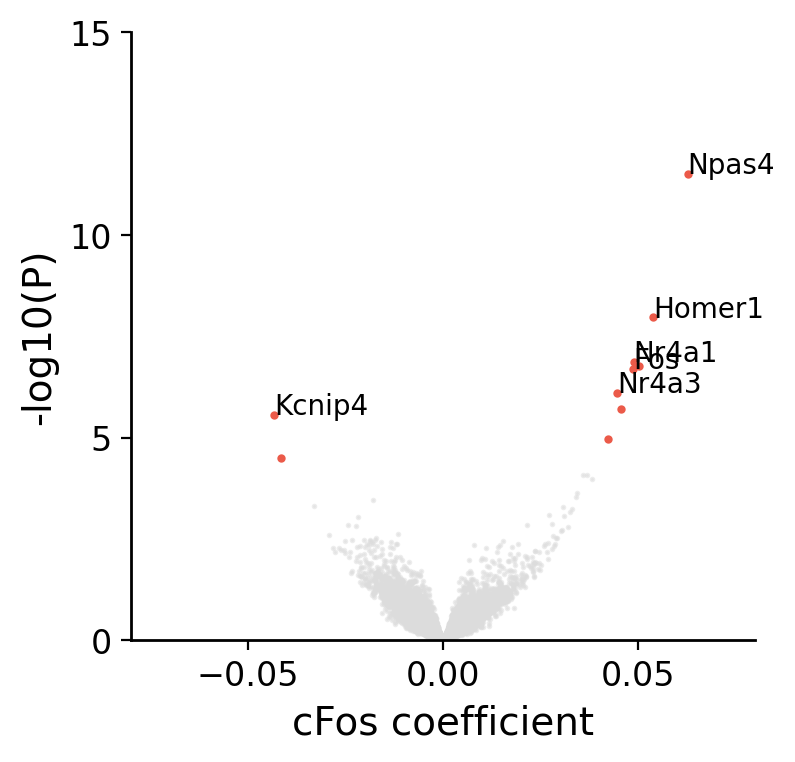

In [6]:
prot = 'cFos'
feat = '%s_nCLR' %prot
volc_df = ict.get_volcano_plot_df_total_model(params_TS, pvals_TS, sig_TS, feat)

ict.plot_pretty_volcano_simplified(volc_df, 
                        annotate=True, 
                        annotate_list=['Homer1','Npas4','Fos','Nr4a1','Nr4a3','Kcnip4'],
                        yticks=[0,5,10,15],
                        xlabel=prot,
                        color='#EB5A49',
                        savefig=True,
                        figdir=sc.settings.figdir,
                        filename='%s_%s_%s' %(casestr_TS, prot, data_mode))
plt.ylim([0,15])
print(volc_df[volc_df['sig']].shape)

Saved volcano_analyses/20210414_revision_combined/volcano_two_step_mixedlm_total_p65_zscore_annotated.pdf
(33, 4)


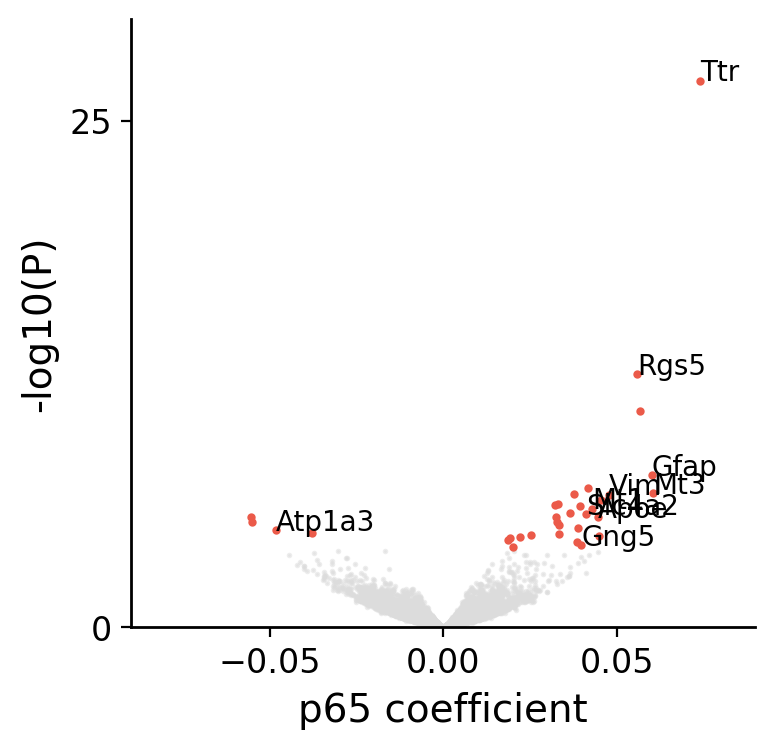

In [7]:
prot = 'p65'
feat = '%s_nCLR' %prot
volc_df = ict.get_volcano_plot_df_total_model(params_TS, pvals_TS, sig_TS, feat)

ict.plot_pretty_volcano_simplified(volc_df, 
                        annotate=True, 
                        annotate_list=['Slc4a2','Mt1','Gfap','Vim','Atp1a3','Ttr','Apoe','Gng5','Rgs5','Mt3'],
                        yticks=[0,25],
                        xlabel=prot,
                        color='#EB5A49',
                        savefig=True,
                        figdir=sc.settings.figdir,
                        filename='%s_%s_%s' %(casestr_TS, prot, data_mode))
print(volc_df[volc_df['sig']].shape)

Saved volcano_analyses/20210414_revision_combined/volcano_two_step_mixedlm_total_PU1_zscore_annotated.pdf
(13, 4)


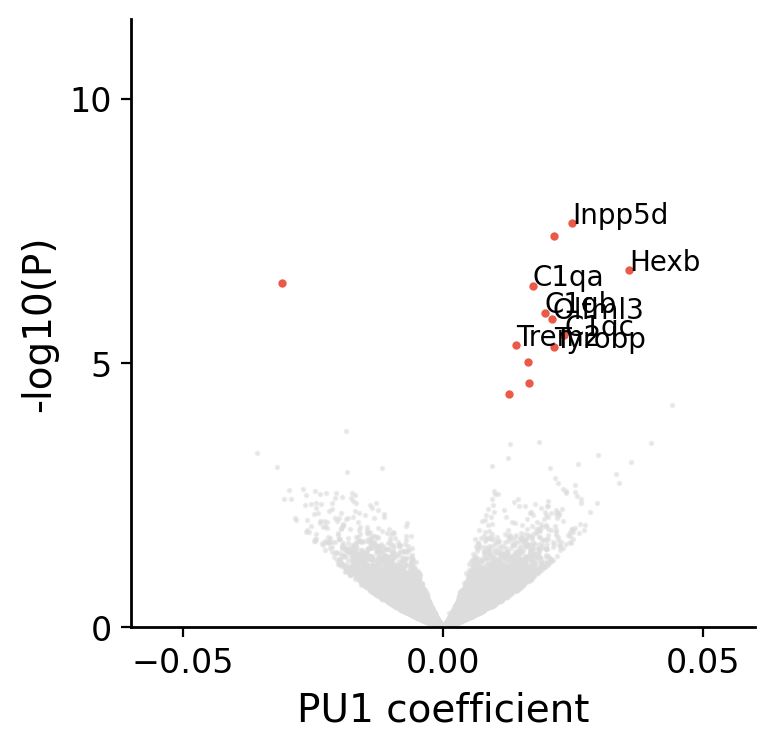

In [8]:
prot = 'PU1'
feat = '%s_nCLR' %prot
volc_df = ict.get_volcano_plot_df_total_model(params_TS, pvals_TS, sig_TS, feat)

ict.plot_pretty_volcano_simplified(volc_df, 
                        annotate=True, 
                        annotate_list=['Tyrobp','Olfml3','C1qb','C1qc','Inpp5d',
                                      'Hexb','C1qa','Trem2'],
                        xticks=[-0.05,0,0.05],
                        yticks=[0,5,10],
                        ylims=[0,11.5],
                        xlabel=prot,
                        color='#EB5A49',
                        savefig=True,
                        figdir=sc.settings.figdir,
                        filename='%s_%s_%s' %(casestr_TS, prot, data_mode))
print(volc_df[volc_df['sig']].shape)

Saved volcano_analyses/20210414_revision_combined/volcano_two_step_mixedlm_total_NeuN_zscore_annotated.pdf


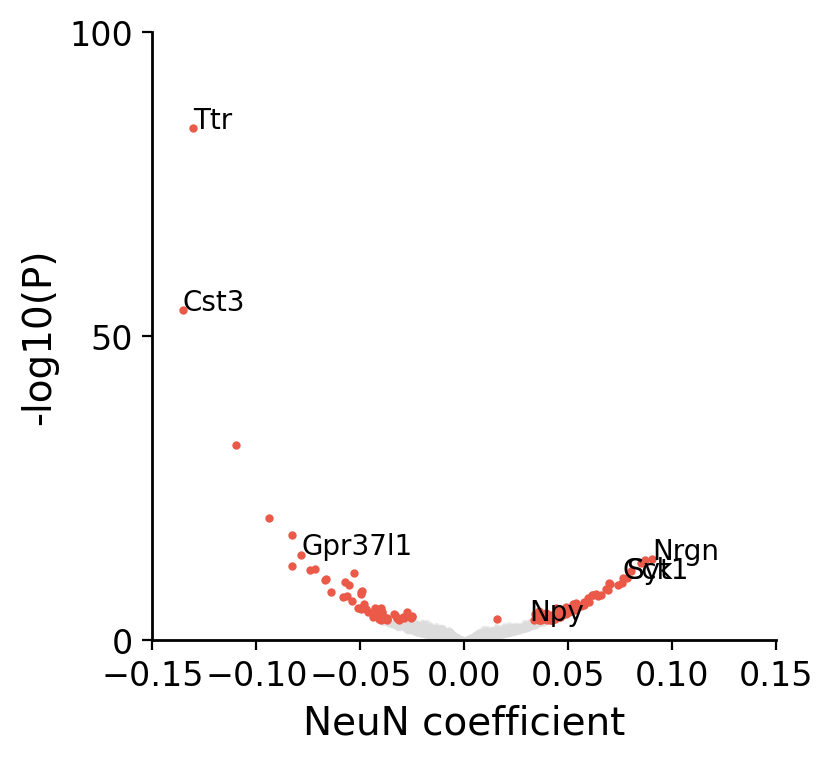

In [9]:
prot = 'NeuN'
feat = '%s_nCLR' %prot
volc_df = ict.get_volcano_plot_df_total_model(params_TS, pvals_TS, sig_TS, feat)

ict.plot_pretty_volcano_simplified(volc_df, 
                        annotate=True, 
                        annotate_list=NeuN_annot,
                        yticks=[0,50,100],
                        xlabel=prot,
                        color='#EB5A49',
                        savefig=True,
                        figdir=sc.settings.figdir,
                        filename='%s_%s_%s' %(casestr_TS, prot, data_mode))

## GO analysis

Saving to analyses/20210414_revision_combined/GO_hbar_mixedlm_zscore_cFos.pdf


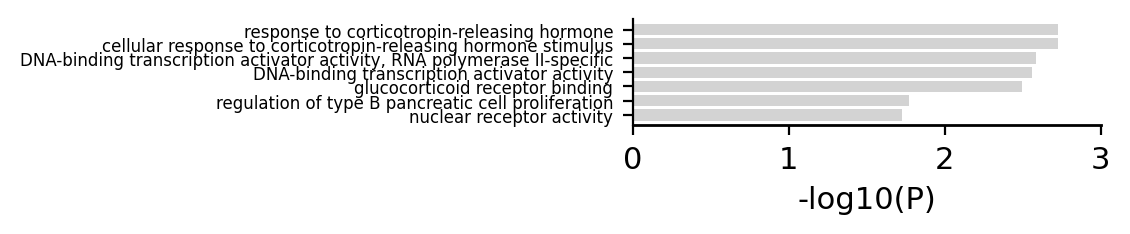

In [10]:
prot = 'cFos'
feat = '%s_nCLR' %prot
sig_genes = pvals_TS[(sig_TS[feat])]
GO_terms = ict.parse_GO_query(list(sig_genes.index), 'mmusculus', db_to_keep=['GO:BP','GO:MF'])
ict.plot_GO_terms(GO_terms.head(7), 0.05, 'mixedlm_%s_%s' %(data_mode, prot), xlims=[0,3])

Saving to analyses/20210414_revision_combined/GO_hbar_mixedlm_zscore_p65.pdf


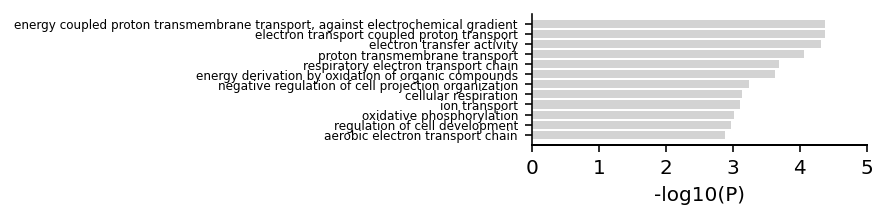

In [11]:
prot = 'p65'
feat = '%s_nCLR' %prot
sig_genes = pvals_TS[(sig_TS[feat])]
GO_terms = ict.parse_GO_query(list(sig_genes.index), 'mmusculus', db_to_keep=['GO:BP','GO:MF'])
ict.plot_GO_terms(GO_terms.head(12), 0.05, 'mixedlm_%s_%s' %(data_mode, prot), xlims=[0,5])

Saving to analyses/20210414_revision_combined/GO_hbar_mixedlm_zscore_PU1.pdf


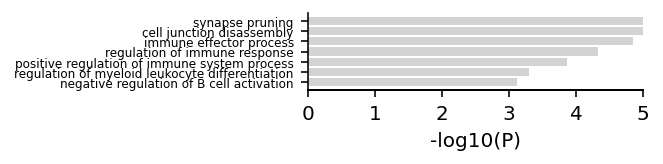

In [12]:
prot = 'PU1'
feat = '%s_nCLR' %prot
sig_genes = pvals_TS[(sig_TS[feat])]
GO_terms = ict.parse_GO_query(list(sig_genes.index), 'mmusculus', db_to_keep=['GO:BP','GO:MF'])
ict.plot_GO_terms(GO_terms.head(7), 0.05, 'mixedlm_%s_%s' %(data_mode, prot), xlims=[0,5])

# Identifying TF-associated genes with linear models

## Additive model

In [13]:
# set number of genes to test

obs_frac = 0.03
n_ex = sum(adata_grouped.obs['annot']=='EX_neuron')
ex_min_genes = np.floor(obs_frac*n_ex)
print(n_ex, ex_min_genes)

15226 456.0


In [16]:
formula1 = 'Gene ~ log_ncounts + log_hashtag_counts + C(assignment)'
formula2 = 'Resid ~ cFos_nCLR + p65_nCLR + NeuN_nCLR + PU1_nCLR'

params_TSC, pvals_TSC = ict.combine_model_across_clusters_two_step(adata_grouped,  
                                    formula1, formula2,  
                                    run_class='mixedlm_two_step_0519_v2_minobs_lims',
                                    clusters=['EX_neuron'],
                                    model='mixedlm', run_mode='zscore',
#                                     run_repeat=True,
                                    min_obs=[ex_min_genes])

sig_TSC = dict.fromkeys(pvals_TSC.keys())
for variate in sig_TSC.keys(): 
    sig_TSC[variate] = ict.get_significance_df(pvals_TSC[variate], method='fdr_bh', alpha=0.05)
    print(variate)
    print(sig_TSC[variate].sum())

EX_neuron
Loading prior run result
mixedlm model with zscore for cluster EX_neuron
Intercept
EX_neuron    0
dtype: int64
cFos_nCLR
EX_neuron    46
dtype: int64
p65_nCLR
EX_neuron    48
dtype: int64
NeuN_nCLR
EX_neuron    245
dtype: int64
PU1_nCLR
EX_neuron    2
dtype: int64
Group Var
EX_neuron    0
dtype: int64


Saved volcano_analyses/20210414_revision_combined/volcano_twostep_model_cFos_nCLR_EX_neuron_zscore_annotated.pdf
Saved volcano_analyses/20210414_revision_combined/volcano_twostep_model_p65_nCLR_EX_neuron_zscore_annotated.pdf


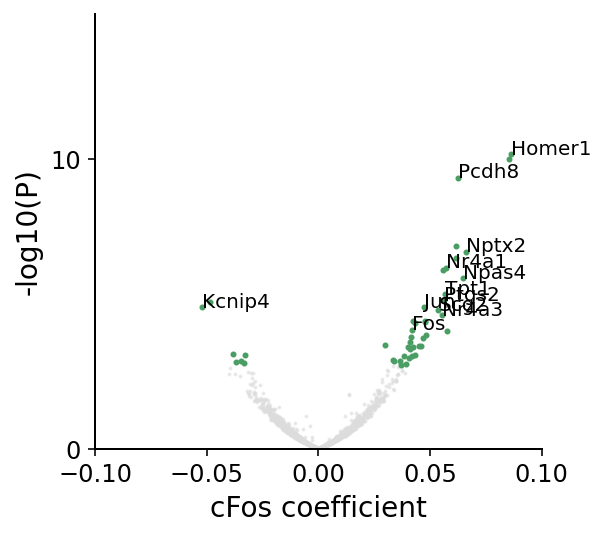

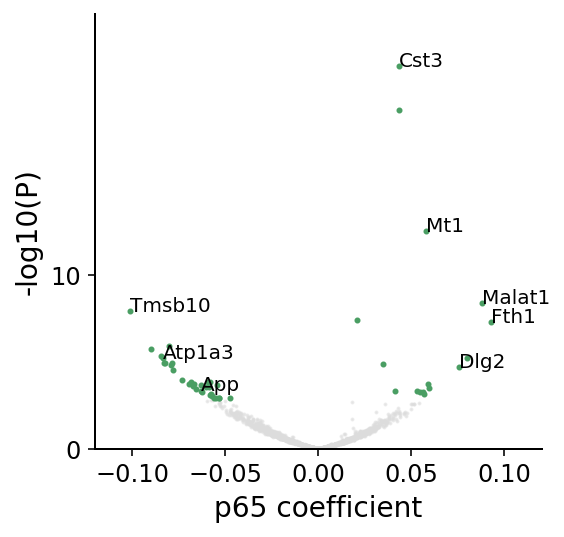

In [18]:
prot = 'cFos'
feat = '%s_nCLR' %prot
for clust in ['EX_neuron']:
    df_plot = ict.get_volcano_plot_df(params_TSC, pvals_TSC, sig_TSC, feat, clust)
    ict.plot_pretty_volcano_simplified(df_plot, 
                            annotate=True, 
                            annotate_list=['Homer1','Npas4','Scg2','Nr4a1','Ptgs2','Fos','Tpt1',
                                          'Nr4a3','Kcnip4','Nptx2','Pcdh8','Jun'],
                            yticks=[0,10],
                            xlabel='cFos', 
                            savefig=True,
                            color=broad_cluster_colors[clust],
                            figdir=sc.settings.figdir,
                            filename='%s_%s_%s_%s' %('twostep_model', feat, clust, 'zscore'))

prot = 'p65'
feat = '%s_nCLR' %prot
for clust in ['EX_neuron']:
    df_plot = ict.get_volcano_plot_df(params_TSC, pvals_TSC, sig_TSC, feat, clust)
    ict.plot_pretty_volcano_simplified(df_plot, 
                            annotate=True, 
                            annotate_list=['Cst3','App','Atp1a3','Mt1','Malat1',
                                           'Tmsb10','Fth1','Dlg2'],
                            yticks=[0,10],
                            xlabel='p65', 
                            savefig=True,
                            color=broad_cluster_colors[clust],
                            figdir=sc.settings.figdir,
                            filename='%s_%s_%s_%s' %('twostep_model', feat, clust, 'zscore'))

In [19]:
# get list of genes for TF motif analysis
for g in sig_TSC['p65_nCLR'][sig_TSC['p65_nCLR']['EX_neuron']].index: 
    print(g)

1110008P14Rik
Adcy1
Aldoa
App
Asns
Atp1a3
Atp2b2
Calm2
Caln1
Caly
Camk2n2
Cst3
Ctsb
Dlg2
Dnm1
Dusp1
Fth1
Fxyd7
Hsd17b12
Kcnb1
Kcnip4
Magi2
Malat1
Mt1
Mt2
Nkain2
Nrxn1
Nrxn3
Olfm1
Ppp3ca
Ptgds
Ptprz1
Rabac1
Resp18
Rnf208
Rpl19
Scn1b
Serpini1
Sncb
Sv2a
Syt13
Tecr
Tmeff2
Tmsb10
Trappc9
Ttc9b
Ttr
Ypel3


## Interaction model

In [21]:
formula1 = 'Gene ~ log_ncounts + log_hashtag_counts + C(assignment)'
formula2 = 'Resid ~ cFos_nCLR + p65_nCLR + NeuN_nCLR + PU1_nCLR + cFos_nCLR:p65_nCLR + cFos_nCLR:NeuN_nCLR + p65_nCLR:NeuN_nCLR'

params_TSI, pvals_TSI = ict.combine_model_across_clusters_two_step(adata_grouped,  
                                    formula1, formula2,  
                                    run_class='mixedlm_two_step_interaction_0519_v2_minobs_lims',
                                    clusters=['EX_neuron'], 
                                    model='mixedlm', run_mode='zscore',
#                                     run_repeat=True,
                                    min_obs=[ex_min_genes])

sig_TSI = dict.fromkeys(pvals_TSI.keys())
for variate in sig_TSI.keys(): 
    sig_TSI[variate] = ict.get_significance_df(pvals_TSI[variate], method='fdr_bh', alpha=0.05) 
    print(variate)
    print(sig_TSI[variate].sum())

EX_neuron
Loading prior run result
mixedlm model with zscore for cluster EX_neuron
Intercept
EX_neuron    0
dtype: int64
cFos_nCLR
EX_neuron    60
dtype: int64
p65_nCLR
EX_neuron    26
dtype: int64
NeuN_nCLR
EX_neuron    289
dtype: int64
PU1_nCLR
EX_neuron    2
dtype: int64
cFos_nCLR:p65_nCLR
EX_neuron    56
dtype: int64
cFos_nCLR:NeuN_nCLR
EX_neuron    56
dtype: int64
p65_nCLR:NeuN_nCLR
EX_neuron    14
dtype: int64
Group Var
EX_neuron    0
dtype: int64


Saved volcano_analyses/20210414_revision_combined/volcano_twostep_interaction_model_cFos_nCLR:p65_nCLR_EX_neuron_zscore_annotated.pdf
Saved volcano_analyses/20210414_revision_combined/volcano_twostep_interaction_model_cFos_nCLR:NeuN_nCLR_EX_neuron_zscore_annotated.pdf
Saved volcano_analyses/20210414_revision_combined/volcano_twostep_interaction_model_p65_nCLR:NeuN_nCLR_EX_neuron_zscore_annotated.pdf


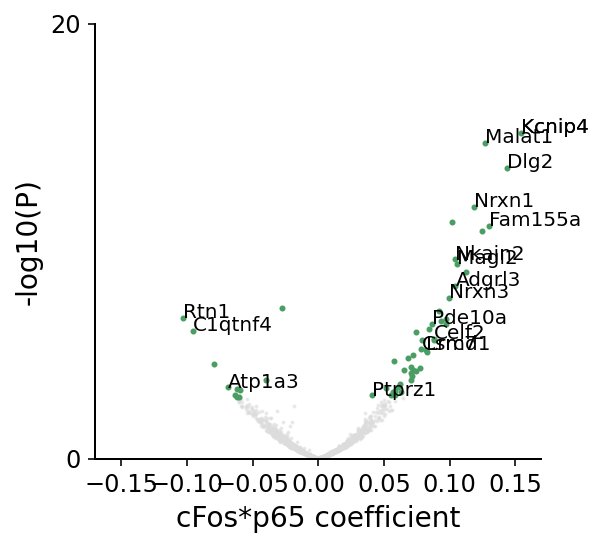

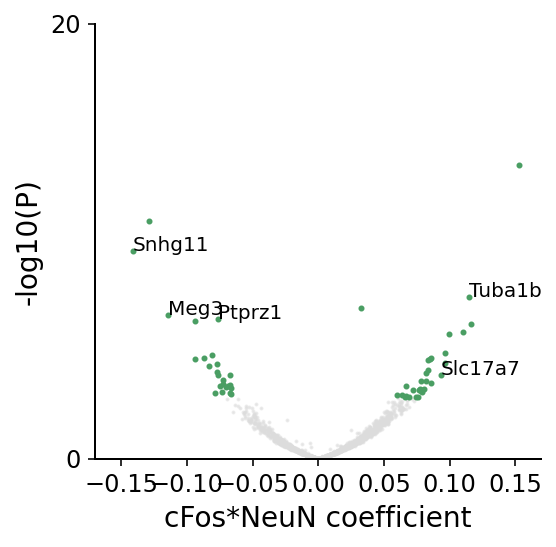

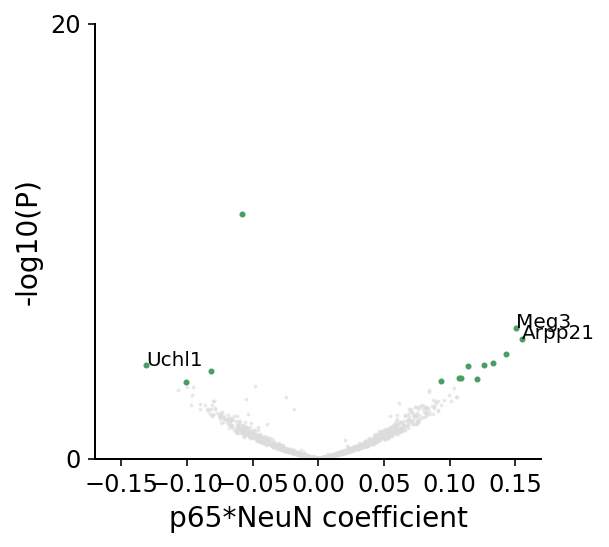

In [22]:
feat = 'cFos_nCLR:p65_nCLR'
for clust in ['EX_neuron']:
    df_plot = ict.get_volcano_plot_df(params_TSI, pvals_TSI, sig_TSI, feat, clust)
    ict.plot_pretty_volcano_simplified(df_plot, 
                            annotate=True, 
                            annotate_list=['Nrxn3','Nkain2','Magi2','Kcnip4','Malat1','Dlg2',
                                           'Ptprz1', 'Adgrl3', 'Nrxn1',
                                           'Atp1a3',
                                           'Fam155a','Kcnip4','Celf2','Lrrc7','Pde10a',
                                          'Csmd1','Rtn1','C1qtnf4'],
                            yticks=[0,20],
                            xlabel='cFos*p65', 
                            savefig=True,
                            color=broad_cluster_colors[clust],
                            figdir=sc.settings.figdir,
                            filename='%s_%s_%s_%s' %('twostep_interaction_model', feat, clust, 'zscore'))
    
feat = 'cFos_nCLR:NeuN_nCLR'
for clust in ['EX_neuron']:
    df_plot = ict.get_volcano_plot_df(params_TSI, pvals_TSI, sig_TSI, feat, clust)
    ict.plot_pretty_volcano_simplified(df_plot, 
                            annotate=True, 
                            annotate_list=['Tuba1b','Slc17a7','Snhg11','Ptprz1','Meg3'],
                            yticks=[0,20],
                            xlabel='cFos*NeuN', 
                            savefig=True,
                            color=broad_cluster_colors[clust],
                            figdir=sc.settings.figdir,
                            filename='%s_%s_%s_%s' %('twostep_interaction_model', feat, clust, 'zscore'))
    
feat = 'p65_nCLR:NeuN_nCLR'
for clust in ['EX_neuron']:
    df_plot = ict.get_volcano_plot_df(params_TSI, pvals_TSI, sig_TSI, feat, clust)
    ict.plot_pretty_volcano_simplified(df_plot, 
                            annotate=True, 
                            annotate_list=['Meg3','Arpp21','Uchl1',],
                            yticks=[0,20],
                            xlabel='p65*NeuN', 
                            savefig=True,
                            color=broad_cluster_colors[clust],
                            figdir=sc.settings.figdir,
                            filename='%s_%s_%s_%s' %('twostep_interaction_model', feat, clust, 'zscore'))

# Pairwise co-expression of c-Fos and p65 associated genes

## Additive model

Saving to analyses/20210414_revision_combined/DEGs_cross_corr_cluster_EX_neuron_cFos_p65.pdf


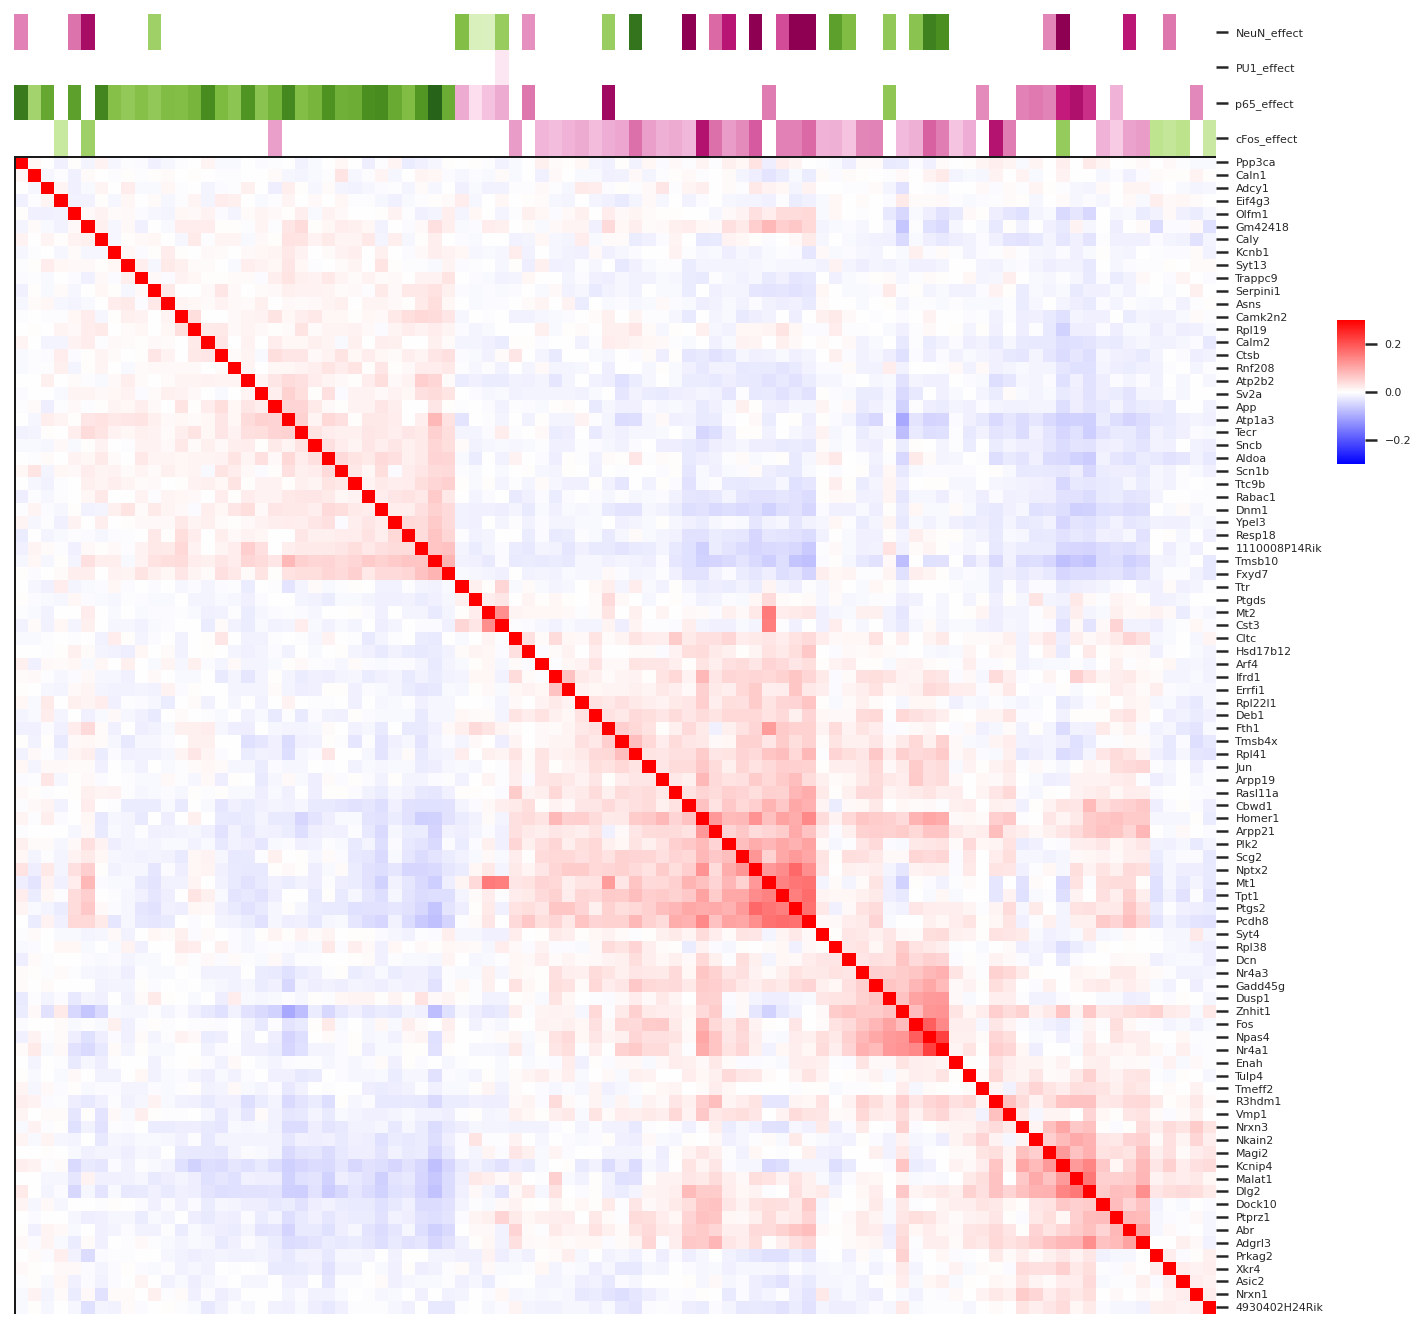

In [23]:
df1, genes_color = ict.pairwise_corr(adata_grouped, params_TSC, sig_TSC, 'EX_neuron', interaction=False)

sns.set(font_scale=0.5)
g = sns.clustermap(df1, 
                xticklabels=[], 
                yticklabels=df1.index,
                col_colors=genes_color,
                metric='seuclidean',
                vmin=-0.3, vmax=0.3, 
                cmap='bwr',
                dendrogram_ratio=0.08, 
                colors_ratio=0.025,
                cbar_pos=[1,0.6,0.02,0.1])
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
ax = g.ax_heatmap
ax.axhline(y=0, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
sns.reset_orig()

figname = '%s/DEGs_cross_corr_cluster_%s.pdf' %(sc.settings.figdir, 'EX_neuron_cFos_p65')
print('Saving to %s' %figname)
plt.savefig(figname, bbox_inches='tight')
sns.reset_orig()

## Interaction model

Saving to analyses/20210414_revision_combined/DEGs_cross_corr_cluster_EX_neuron_cFos_p65_interaction.pdf


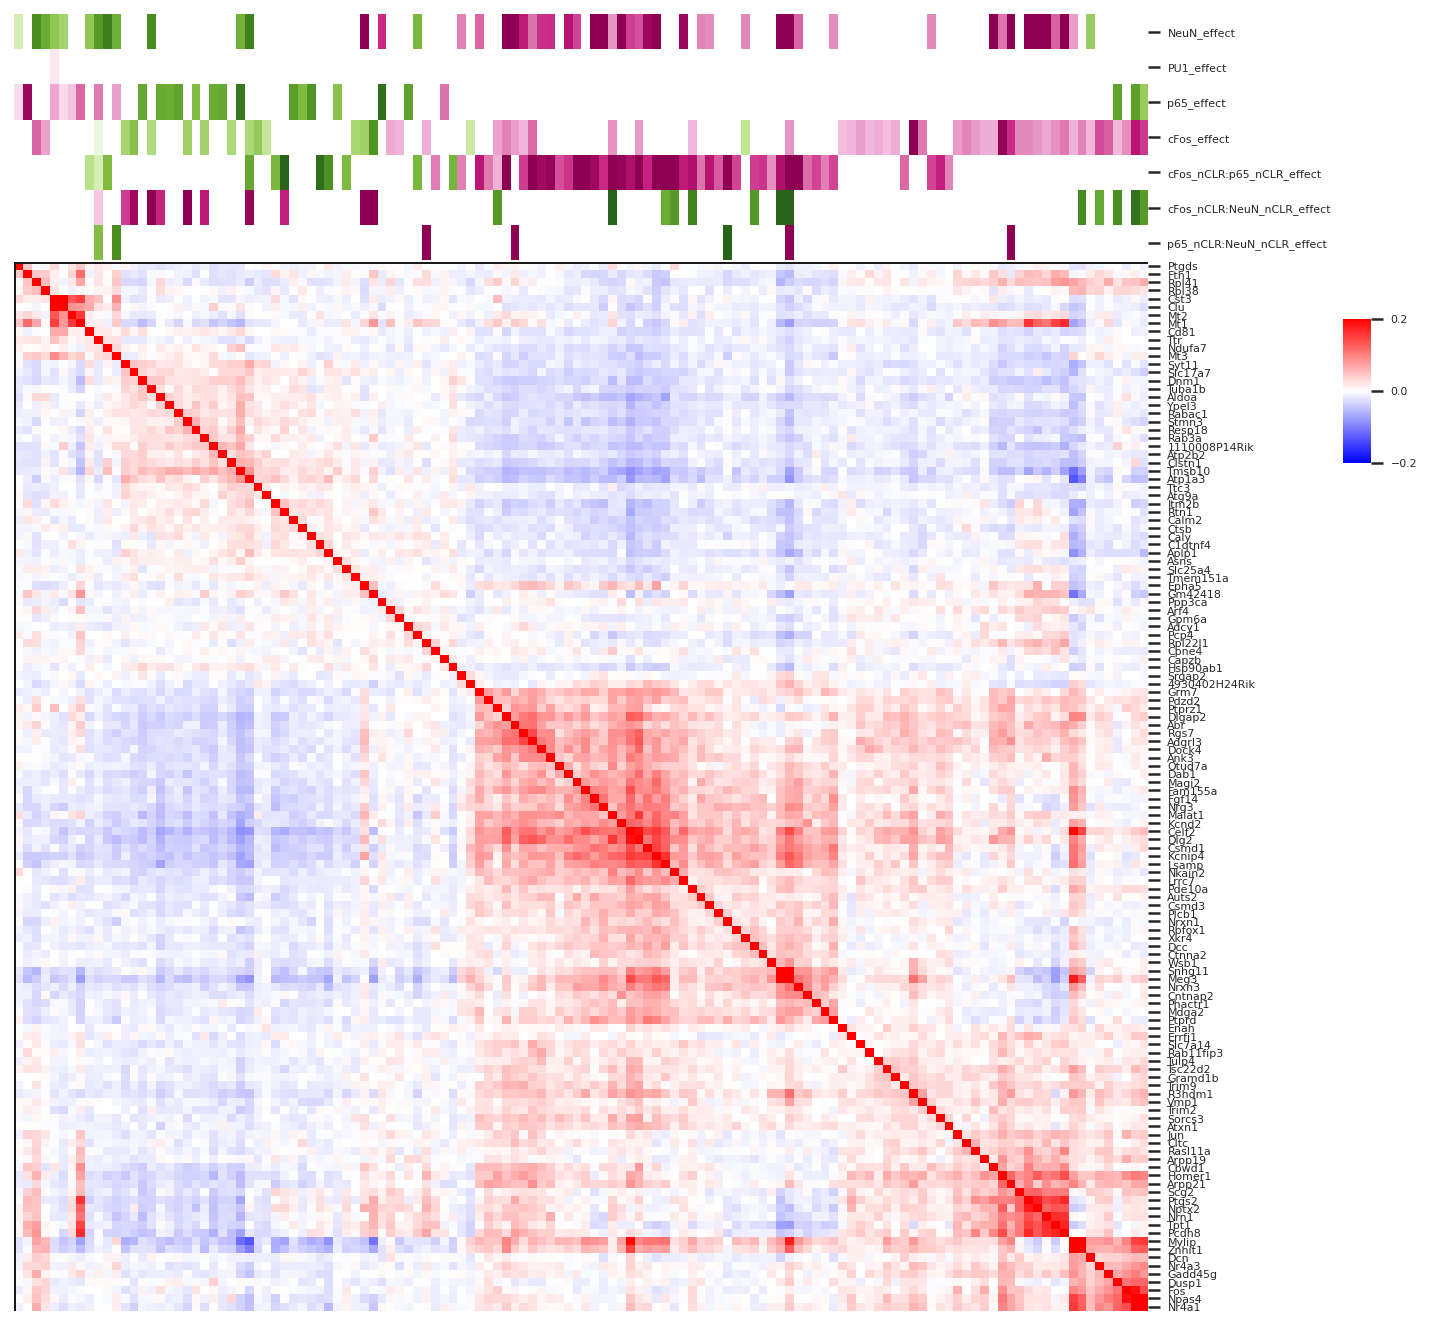

In [27]:
df1, genes_color = ict.pairwise_corr(adata_grouped, params_TSI, sig_TSI, 'EX_neuron', interaction=True)

sns.set(font_scale=0.5)
g = sns.clustermap(df1, 
                xticklabels=[], 
                yticklabels=df1.index,
                col_colors=genes_color,
                vmin=-0.2, vmax=0.2, 
                cmap='bwr',
                metric='euclidean', 
                dendrogram_ratio=0.08, 
                colors_ratio=0.025,
                cbar_pos=[1,0.6,0.02,0.1])
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
ax = g.ax_heatmap
ax.axhline(y=0, color='k',linewidth=2)
ax.axvline(x=0, color='k',linewidth=2)
sns.reset_orig()

figname = '%s/DEGs_cross_corr_cluster_%s.pdf' %(sc.settings.figdir, 'EX_neuron_cFos_p65_interaction')
print('Saving to %s' %figname)
plt.savefig(figname, bbox_inches='tight')
sns.reset_orig()


In [25]:
feat1 = 'cFos_nCLR'
feat2 = 'p65_nCLR'
feat_mixed = '%s:%s' %(feat1, feat2)
cluster = 'EX_neuron'
mixture_genes = sig_TSI[feat_mixed][sig_TSI[feat_mixed][cluster]]
cFos_ct = 0
p65_ct = 0
for g in mixture_genes.index:
#     print(g)
    f1 = sig_TSC[feat1].loc[g,cluster]
    f2 = sig_TSC[feat2].loc[g,cluster]
    if f1 | f2: 
        print(g, feat1, f1, feat2, f2)
    if f1: cFos_ct+=1
    if f2: p65_ct+=1
    

Adgrl3 cFos_nCLR True p65_nCLR False
Atp1a3 cFos_nCLR False p65_nCLR True
Dlg2 cFos_nCLR False p65_nCLR True
Kcnip4 cFos_nCLR True p65_nCLR True
Magi2 cFos_nCLR False p65_nCLR True
Malat1 cFos_nCLR False p65_nCLR True
Nkain2 cFos_nCLR False p65_nCLR True
Nrxn1 cFos_nCLR False p65_nCLR True
Nrxn3 cFos_nCLR False p65_nCLR True
Ptprz1 cFos_nCLR True p65_nCLR True
Ttr cFos_nCLR False p65_nCLR True


In [26]:
print(cFos_ct, p65_ct)

3 10


# NMF-derived gene programs within cell types 

In [28]:
# import clustered data using inCITE data only to get HVGs
adata_inCITE = sc.read('./write/revision_inCITE_clustered.h5ad')
HVGs = adata_inCITE.var[adata_inCITE.var['highly_variable']].index

In [29]:
def run_NMF(ad, N_MODULES=6, top_N=15, l1_ratio=1, alpha=0, plot=True, savefig=True, figstr='', mod_base='module'): 
    from sklearn.decomposition import NMF
    model = NMF(n_components=N_MODULES, init='random', random_state=0, alpha=alpha, l1_ratio=l1_ratio)
    X = ad.layers['counts'].toarray()
    cell_by_module = model.fit_transform(X)
    modules_by_gene = model.components_
    
    df_cell_x_module = pd.DataFrame(cell_by_module, 
                                    index=ad.obs.index, 
                                    columns=['%s%i' %(mod_base,i) for i in range(N_MODULES)])
    df_module_x_gene = pd.DataFrame(modules_by_gene, 
                                    index=['%s%i' %(mod_base,i) for i in range(N_MODULES)], 
                                    columns=ad.var.index)

    genes = ad.var.index
    module_genes = {}
    for i in range(N_MODULES): 
        fig, (ax1, ax2) = plt.subplots(1,2,sharey=False, figsize=(4,3),
                                      gridspec_kw={'width_ratios': [1, 2]})
        
        # get sorted genes contributing to each module
        module_genes_sorted, genes_sorted = ict.sorted_module_genes(modules_by_gene, i, genes, top_N)
        
        # calculate correlation between gene expr and module score across cells
        top_genes = genes_sorted[:top_N]
        corrs = ict.corr_geneset_vs_module(ad, top_genes, cell_by_module[:,i])
        
        # sort by descending correlation 
        corr_idx = list(np.argsort(corrs))
        corr_idx.reverse()
        top_genes_sorted = [top_genes[i] for i in corr_idx]
        corrs_sorted = [corrs[i] for i in corr_idx]
        
        # bar plot of top module genes
        if plot: 
            ict.plot_top_genes_per_module(ax1, corrs_sorted, top_genes_sorted)

            # umap of module scores scores
            ad.obs['%s%i' %(mod_base,i)] = cell_by_module[:,i]
            sc.pl.umap(ad, color=['%s%i' %(mod_base,i)], ax=ax2, frameon=False, color_map='coolwarm')

            # add to top module genes
            module_genes[str(i)] = list(top_genes_sorted)

            if savefig: 
                figname = '%s/run_NMF_%s%i_%s.pdf' %(sc.settings.figdir, mod_base, i, figstr)
                print('Saving to %s' %figname)
                fig.savefig(figname, bbox_inches='tight')
    
    genes_to_mods = ict.rev_dict_list(module_genes)
    
    return df_cell_x_module, df_module_x_gene, module_genes,genes_to_mods

## Gene programs in excitatory neurons

In [30]:
# subset features and clusters for NMF
NMF_clusters = ['EX_neuron']
ad_NMF, NMF_genes = ict.subset_feats_clusters_NMF(NMF_clusters, sig_TSC, adata_grouped, HVGs, 
                                                  add_NMF_genes=True,
                                                  remove_ribo=True)

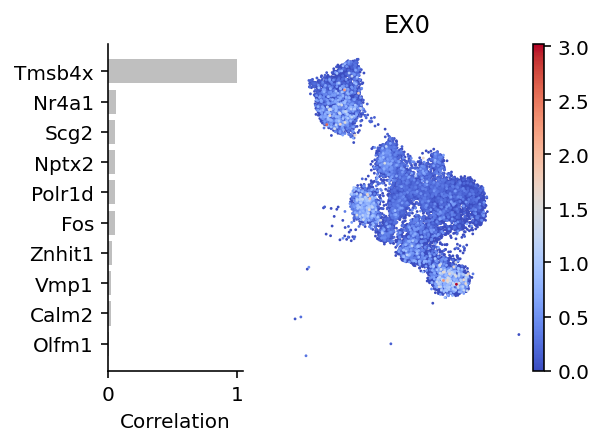

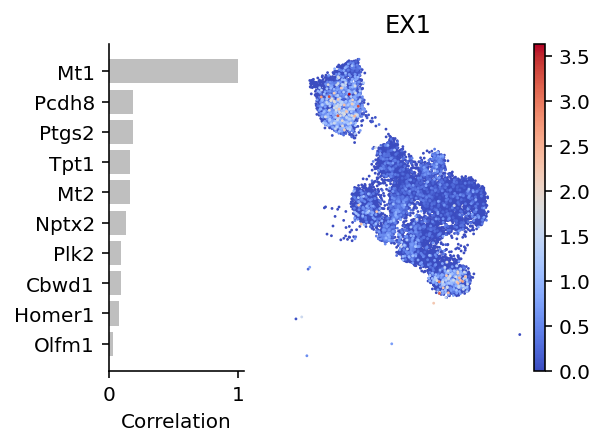

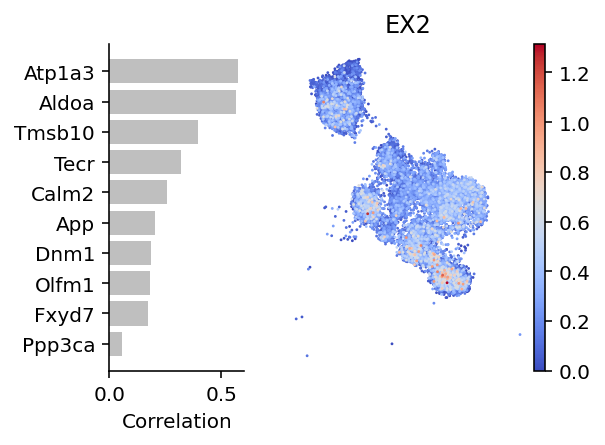

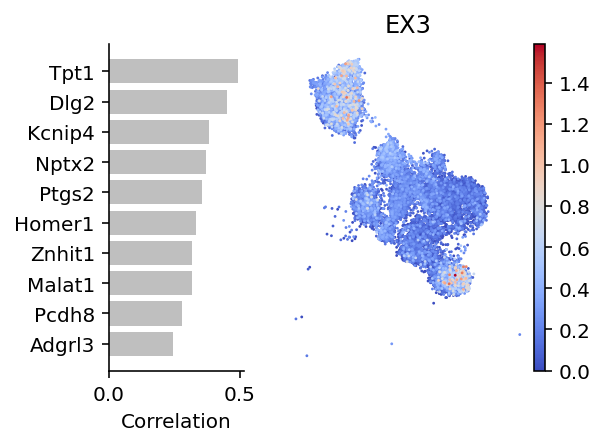

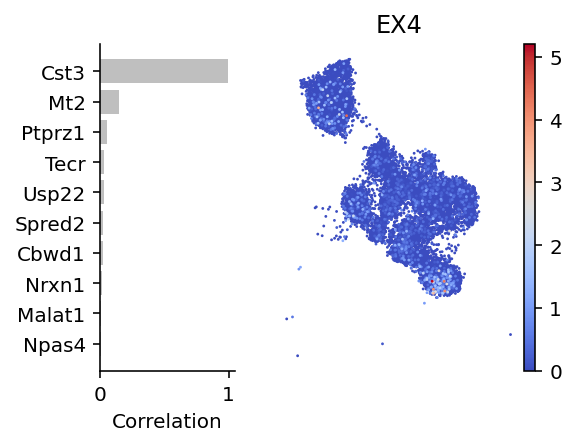

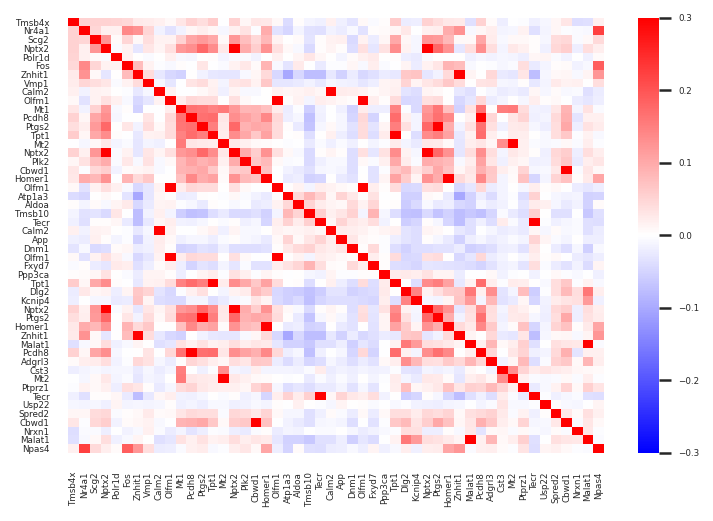

In [31]:
N_MODULES = 5
mod_base = 'EX'
cell_x_module, module_x_gene, module_genes, ict.genes_to_modules = run_NMF(ad_NMF, N_MODULES=N_MODULES, 
                                                                       top_N=10,
                                                                       l1_ratio=1, 
                                                                       alpha=0, 
                                                                       mod_base=mod_base,
                                                                       plot=True,
                                                                       savefig=False, 
                                                                       figstr='EX_neurons_%i_modules' %N_MODULES)
modules = ['%s%i' %(mod_base,i) for i in range(N_MODULES)]
top_module_genes = list(set([item for sublist in module_genes.values() for item in sublist]))
ict.heatmap_module_genes(ad_NMF, module_genes)

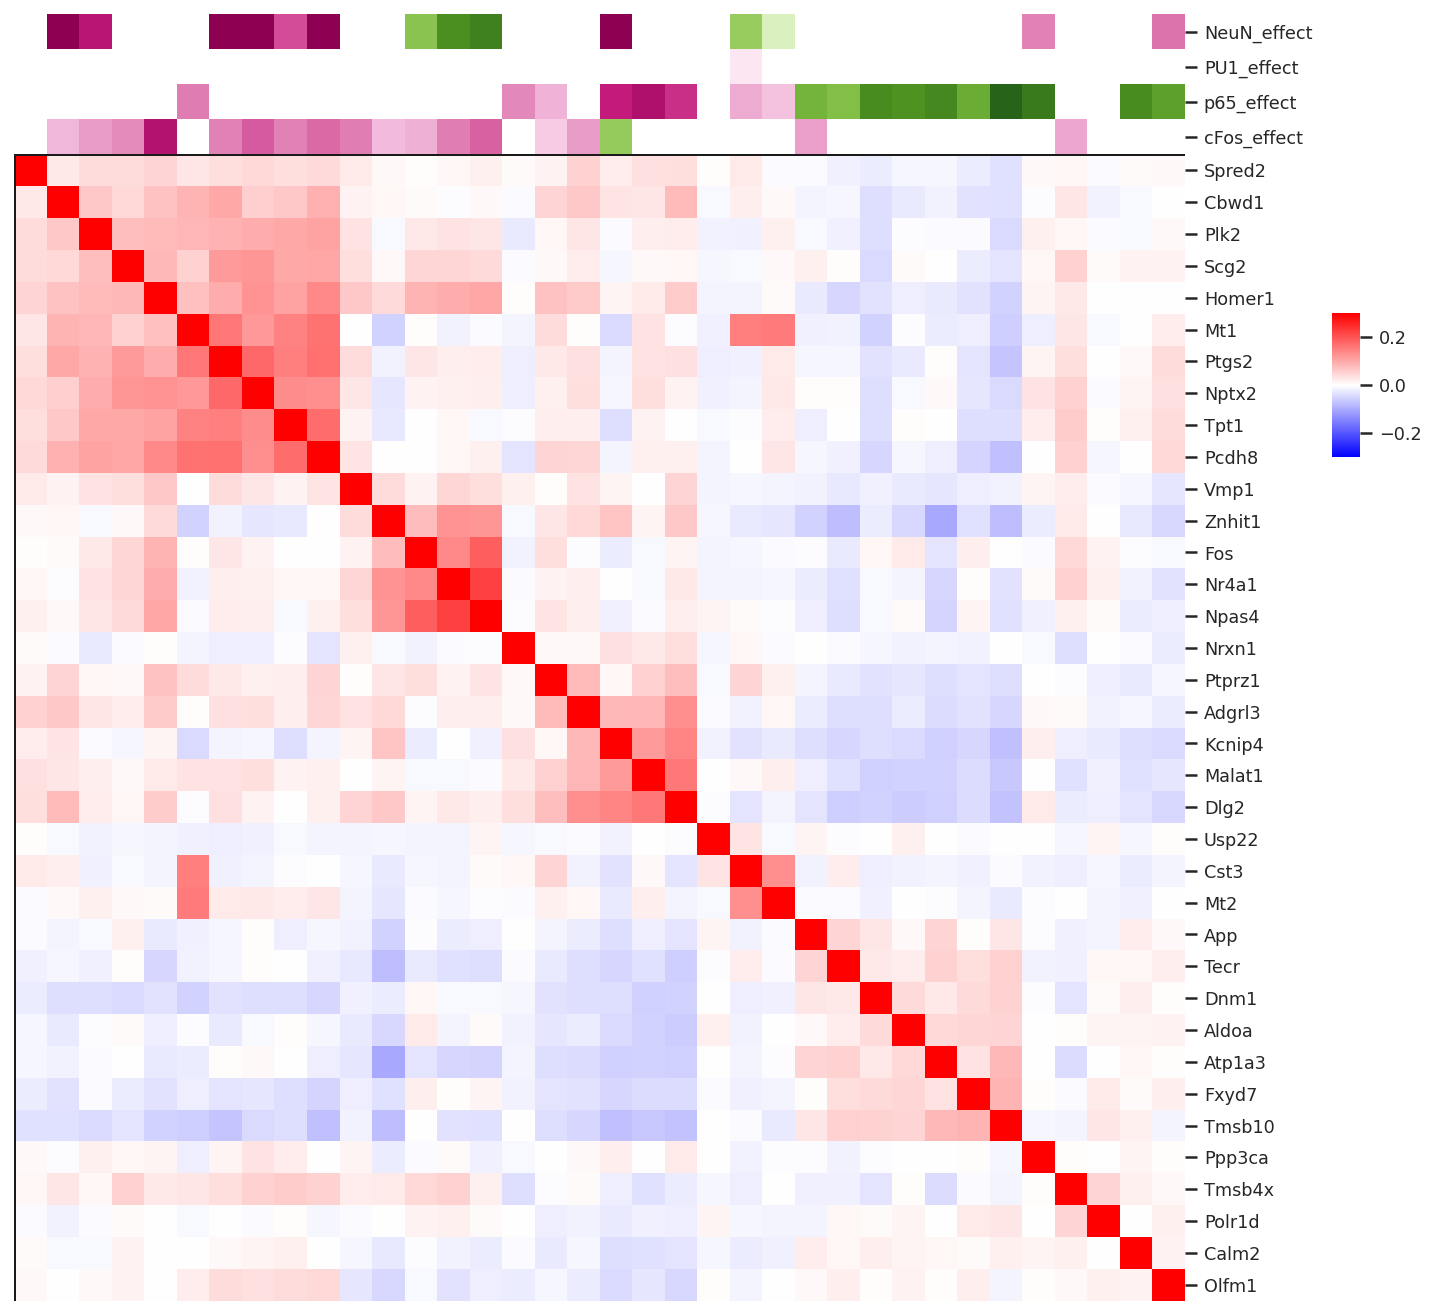

In [32]:
DEG_corr = ict.get_corr_df(ad_NMF, module_genes)
genes_color = ict.gene_feat_colors_cluster(sig_TSC, params_TSC, top_module_genes, NMF_clusters, 
                                       proteins=['NeuN','PU1','p65','cFos'],
                                      colors=['PiYG_r','PiYG_r','PiYG_r','PiYG_r'])
ict.clustermap_corr_DEGs(DEG_corr, genes_color, 'EX_neurons_%i_modules' %N_MODULES, 
                         vmin=-0.3, vmax=0.3, savefig=False)

In [ ]:
ict.make_horizontal_colorbar('PiYG_r', vmin=-0.1, vmax=0.1)

In [ ]:
ict.make_vertical_colorbar('PiYG_r', vmin=-0.1, vmax=0.1)

In [33]:
GO_ex = ict.module_top_GO_terms(module_genes)
GO_ex

,source,name,p_value,significant,description,term_size,query_size,intersection_size,module
0,GO:BP,modulation of chemical synaptic transmission,0.001962,True,"""Any process that modulates the frequency or a...",494,10,5,module1
1,GO:BP,regulation of trans-synaptic signaling,0.001982,True,"""Any process that modulates the frequency, rat...",495,10,5,module1
2,GO:BP,stress response to copper ion,0.003780,True,"""Any process that results in a change in state...",6,10,2,module1
3,GO:BP,detoxification of copper ion,0.003780,True,"""Any process that reduces or removes the toxic...",6,10,2,module1
6,GO:BP,detoxification of inorganic compound,0.009066,True,"""Any process that reduces or removes the toxic...",9,10,2,module1
2,GO:BP,response to amyloid-beta,0.000328,True,"""Any process that results in a change in state...",45,7,3,module2
6,GO:BP,neuron projection maintenance,0.003528,True,"""The organization process that preserves a neu...",9,7,2,module2
10,GO:BP,positive regulation of endocytosis,0.006416,True,"""Any process that activates or increases the f...",120,7,3,module2
19,GO:BP,G protein-coupled receptor internalization,0.014972,True,"""The process that results in the uptake of a G...",18,7,2,module2
21,KEGG,Endocrine and other factor-regulated calcium r...,0.022913,True,Endocrine and other factor-regulated calcium r...,61,5,2,module2


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PBS v.s. KainicAcid: t-test independent samples with Bonferroni correction, P_val=1.321e-07 stat=-5.278e+00
Saving to analyses/20210414_revision_combined/module_score_by_treatment_boxplot_EX0.pdf
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PBS v.s. KainicAcid: t-test independent samples with Bonferroni correction, P_val=5.416e-91 stat=-2.037e+01
Saving to analyses/20210414_revision_combined/module_score_by_treatment_boxplot_EX1.pdf
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PBS v.s. KainicAcid: t-test independent samples with Bonferroni correction, P_val=1.062e-03 stat=3.274e+00
Saving to

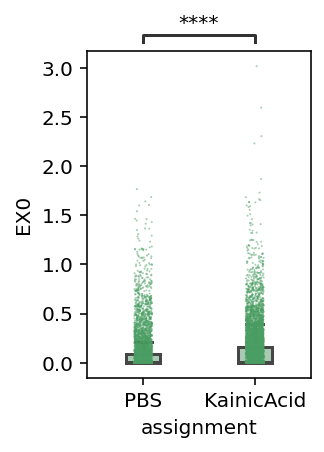

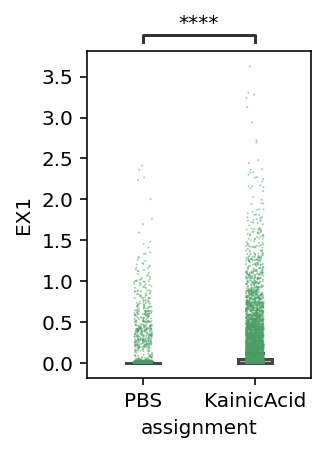

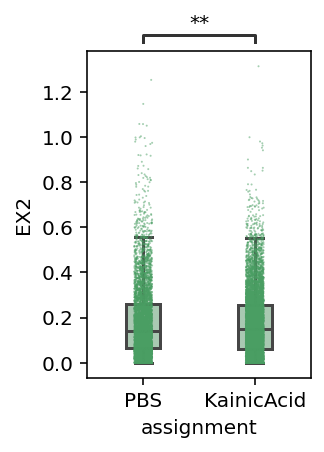

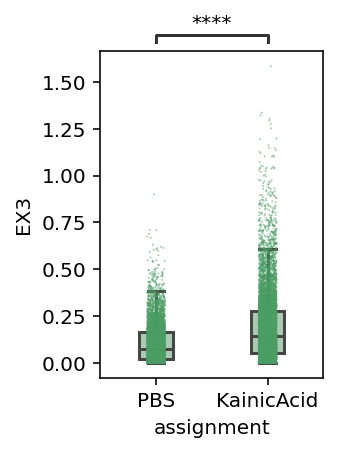

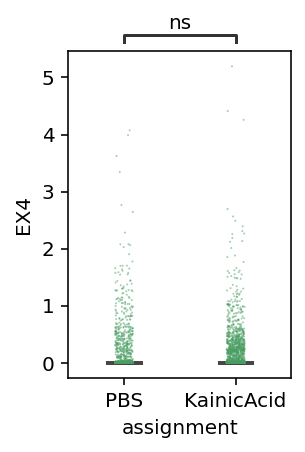

In [34]:
ex_dict = {'PBS': '#4A9E63', 'KainicAcid': '#4A9E63'}
ad_NMF.obs[cell_x_module.columns] = cell_x_module
for mod in modules: 
    ict.module_score_treatment_boxplot(ad_NMF,mod,ex_dict,figstr=mod)

# Treatment-specific global effects of each protein

In [80]:
data_mode = 'zscore' 

params_PBS, pvals_PBS, sig_PBS, casestr_PBS = ict.load_mixedlm_results_total_model(
                                                        ad_inCITE, 'proteins_PBS', data_mode,
                                                        min_obs=15,
                                                        run_repeat=True,
                                                        model_type='mixedlm')

params_KA, pvals_KA, sig_KA, casestr_KA = ict.load_mixedlm_results_total_model(
                                                        ad_inCITE, 'proteins_KA', data_mode,
                                                        min_obs=15,
                                                        run_repeat=True,
                                                        model_type='mixedlm')

Using full adata
Testing genes with min 15 cells
Cluster  with 8999 nuclei and 11601 genes
min max log_ncounts 3.912, 7.077
Running model for all genes
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12745.460495948792
Ran mixedlm model with zscore for cluster  and CITE all
Using full adata
Testing genes with min 15 cells
Cluster  with 13261 nuclei and 12255 genes
min max log_ncounts 3.912, 7.086
Running model for all genes
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
15937.141460418701
Ran mixedlm model with zscore for cluster  and CITE all


## DEG scatter plot of PBS vs. KA coefficients

Saving to %figname
Slope -0.0110 	 R^2 0.0001 	 pval 0.212816
0.00013730756690546716 0.2128164590886995


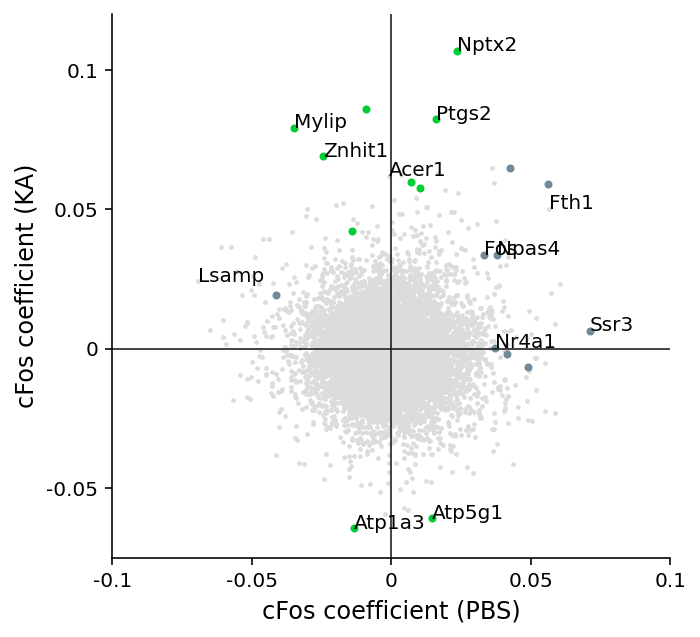

In [128]:
cFos_params = ict.plot_feat_coefficients_PBS_KA('cFos', params_PBS, params_KA, pvals_PBS, 
                                                pvals_KA, sig_PBS, sig_KA, 
                                                  x_sig_lim=None, y_sig_lim=None, 
                                                  GENE_TO_PLOT=['Npas4','Nr4a1','Fos','Fth1',
                                                    'Lsamp','Ssr3','Nptx2','Ptgs2',
                                                   'Znhit1','Acer1','Mylip','Atp5g1','Atp1a3']) 
ict.params_linear_fit(cFos_params)

Saving to %figname
Slope 0.1331 	 R^2 0.0320 	 pval 0.000000
0.03202356882683698 5.360182266702619e-82


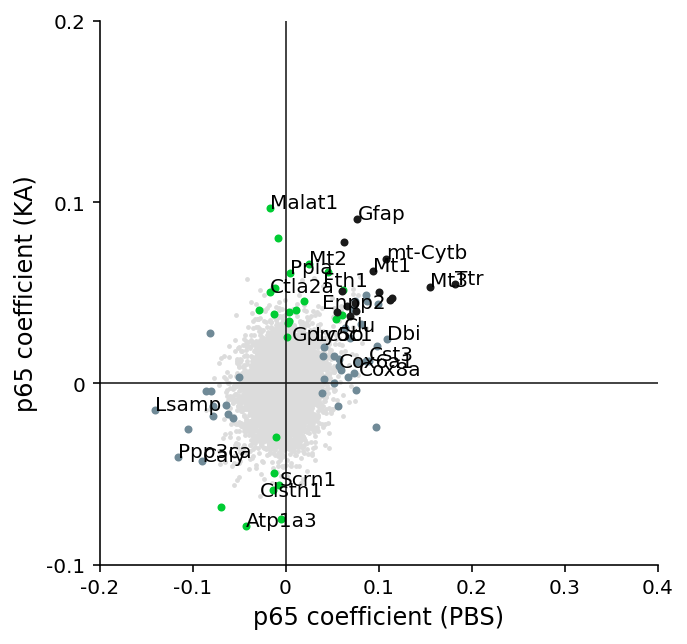

In [117]:
p65_params = ict.plot_feat_coefficients_PBS_KA('p65', params_PBS, params_KA, pvals_PBS, pvals_KA, sig_PBS, sig_KA, 
                                               x_sig_lim=None, y_sig_lim=None, 
                                              GENE_TO_PLOT=['Ttr','Gfap','Enpp2','Dbi','Cst3','Ly6c1','Cox8a',
                                                'Mt1','Mt2','Mt3',
                                                'Gprc5b',
                                                'mt-Cytb','Lsamp','Ppp3ca','Caly',
                                                'Atp1a3', 'Fth1', 'Ctla2a',
                                                'Clu',
                                                'Cox6a1','Ppia','Malat1',
                                                'Scrn1','Clstn1'])
ict.params_linear_fit(p65_params)

Saving to %figname
Slope 0.0427 	 R^2 0.0032 	 pval 0.000000
0.003179707479911668 1.974099426165448e-09


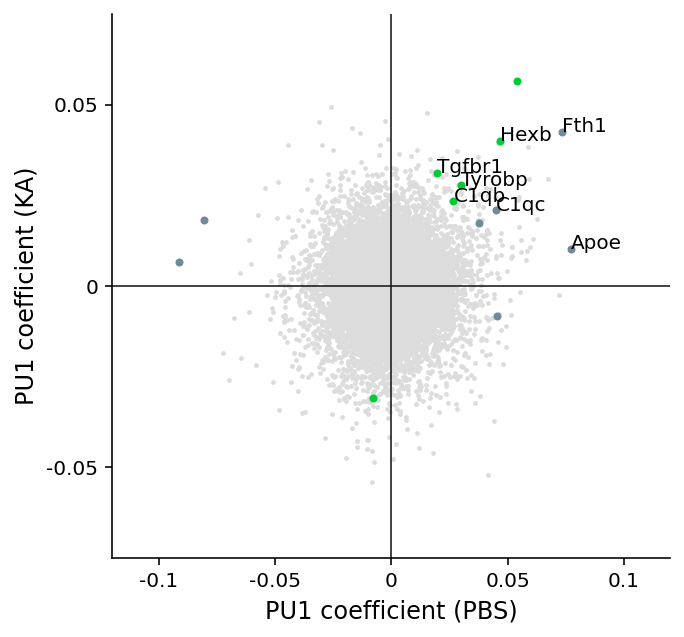

In [123]:
PU1_params = ict.plot_feat_coefficients_PBS_KA('PU1', params_PBS, params_KA, pvals_PBS, 
                                                       pvals_KA, sig_PBS, sig_KA, 
                                                      x_sig_lim=None, y_sig_lim=None,
                                                      GENE_TO_PLOT=['Hexb','Inpp5d','Tyrobp','Apoe',
                                                                    'C1qc','C1qb','Inpp5d','Fth1',
                                                                    'Tgfbr1'])
ict.params_linear_fit(PU1_params)

Saving to %figname
Slope 0.3122 	 R^2 0.1378 	 pval 0.000000
0.13775394979420055 0.0


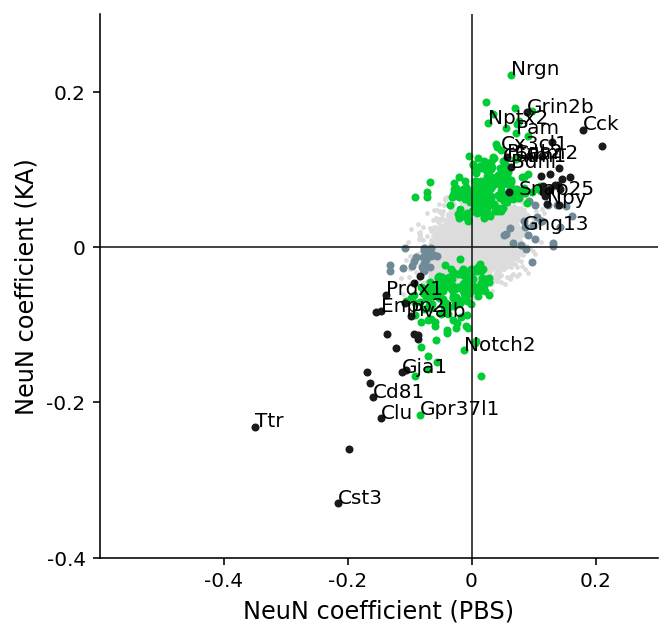

In [124]:
NeuN_params = ict.plot_feat_coefficients_PBS_KA('NeuN', params_PBS, params_KA, pvals_PBS, 
                                                pvals_KA, sig_PBS, sig_KA, 
                                                  x_sig_lim=None, y_sig_lim=None, 
                                                  GENE_TO_PLOT=['Cck','Gng13','Snap25','Npy',
                                                               'Gja1','Cd81','Prdx1','Pvalb','Pam',
                                                                'Nptx2','Nrgn','Grin2b','Calm1',
                                                                'Calm2','Bdnf','Ptgs2','Cx3cl1',
                                                               'Notch2','Gpr37l1','Clu','Ttr','Cst3',
                                                                'Enpp2'])
ict.params_linear_fit(NeuN_params)

# Cell type specific effects after KA treatment

In [135]:
obs_frac = 0.03
ad_CT_KA = ad_CT_grouped[ad_CT_grouped.obs['assignment']=='KainicAcid']
min_genes_list = []
for clust in ad_CT_KA.obs['annot'].cat.categories:
    n_clust = sum(ad_CT_KA.obs['annot']==clust)
    min_genes = np.floor(obs_frac*n_clust)
    min_genes_list.append(min_genes)
    print(clust, n_clust, min_genes)

Ex.Subiculum.CA 1823 54.0
Ex.neuron.mixed 1635 49.0
GABAergic 839 25.0
Astrocyte 1452 43.0
Oligodendrocyte 455 13.0
OPC 165 4.0
ChoroidPlexus 287 8.0
Endothelium 215 6.0
Fibroblast 312 9.0
NPC 146 4.0
Microglia 78 2.0
EX_CA 3968 119.0
EX_GranuleCell 1886 56.0


In [144]:
data_mode = 'zscore'
params_KA_CT, pvals_KA_CT, sig_KA_CT, casestr_KA_CT = ict.load_mixedlm_results_scaled(ad_CT_grouped, 
                                                                            'proteins_KA', 
                                                                            data_mode, 
                                                                            min_obs=min_genes_list, 
#                                                                             run_repeat=True,
                                                                            THRESHOLD=0.05)

Ex.Subiculum.CA
Loading prior run result
Ran mixedlm model with zscore for cluster Ex.Subiculum.CA and CITE all
Ex.neuron.mixed
Loading prior run result
Ran mixedlm model with zscore for cluster Ex.neuron.mixed and CITE all
GABAergic
Loading prior run result
Ran mixedlm model with zscore for cluster GABAergic and CITE all
Astrocyte
Loading prior run result
Ran mixedlm model with zscore for cluster Astrocyte and CITE all
Oligodendrocyte
Loading prior run result
Ran mixedlm model with zscore for cluster Oligodendrocyte and CITE all
OPC
Loading prior run result
Ran mixedlm model with zscore for cluster OPC and CITE all
ChoroidPlexus
Loading prior run result
Ran mixedlm model with zscore for cluster ChoroidPlexus and CITE all
Endothelium
Loading prior run result
Ran mixedlm model with zscore for cluster Endothelium and CITE all
Fibroblast
Loading prior run result
Ran mixedlm model with zscore for cluster Fibroblast and CITE all
NPC
Loading prior run result
Ran mixedlm model with zscore for

## rank plots of DEGs by cell type

In [146]:
def plot_DEG_rank_plot_by_cluster(feat, param, pval, sig, figstr='', annotate=True): 
    sig_genes = {}
    for clust in sig[feat].columns: 

        param_clust = param[feat][clust].loc[~param[feat][clust].isnull()]
        pval_clust = pval[feat][clust].loc[~pval[feat][clust].isnull()]
        sig_clust = sig[feat][clust].loc[~sig[feat][clust].isnull()]

        param_sorted = param_clust.sort_values(ascending=True)
        sig_sorted = sig_clust[param_sorted.index]
        
        # organize gene list
        plot_df = pd.concat([param_sorted, sig_sorted, pd.Series(np.arange(0,len(param_sorted),1), 
                                                       index=param_sorted.index)], 
                              axis=1, keys=['param','sig', 'rank'])
        sig_genes[clust] = plot_df[plot_df['sig']]
        
        # plot 
        fig = plt.figure(figsize=(2,2))
        axes = plt.gca()
        plt.scatter(plot_df[~plot_df['sig']]['rank'], plot_df[~plot_df['sig']]['param'], 
                    s=1, color='#bfbfbf', alpha=0.6)
        plt.scatter(plot_df[plot_df['sig']]['rank'], plot_df[plot_df['sig']]['param'], 
                    s=24, color=annot_to_colors[clust], edgecolors='k', linewidths=0.5)
        
        if annotate:
            for gene, row in plot_df[plot_df['sig']].iterrows(): 
                axes.annotate(gene, (row['rank'], row['param']), 
                                 fontsize=10, fontweight='medium')
            annot_str='_annotate'
        else: 
            annot_str=''
            
        plt.axhline(0, color='k', linewidth=0.5)
        plt.title(clust)
        plt.xticks([1,max(plot_df['rank'])])
        
        max_val = round(max(np.abs(plot_df['param'])),1)+0.1
        plt.ylim([-max_val,max_val])
        plt.yticks([-max_val, 0, max_val])
        
        axes.tick_params(axis='x', labelsize=8)
        axes.tick_params(axis='y', labelsize=8)
        
        fig.savefig('%s/rankplot_DEG_%s_%s_%s%s.pdf' %(sc.settings.figdir, figstr, feat, clust, annot_str),
                   bbox_inches='tight')

    return sig_genes

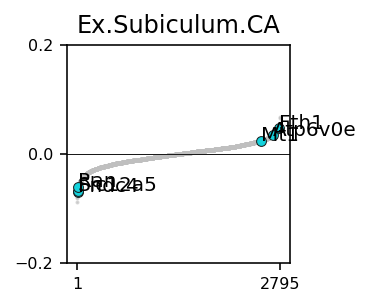

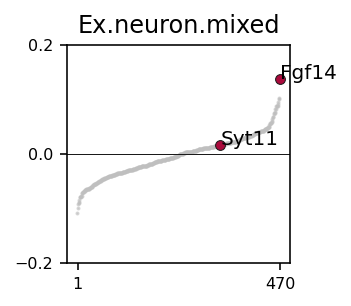

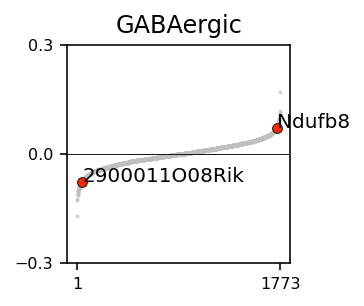

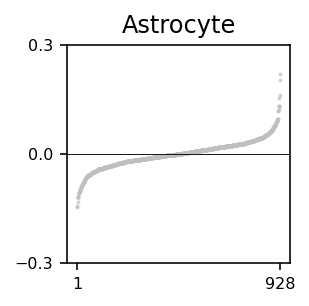

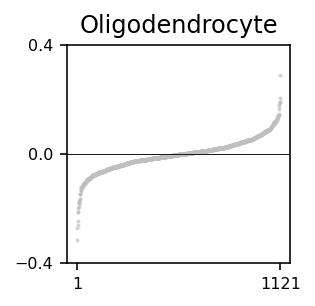

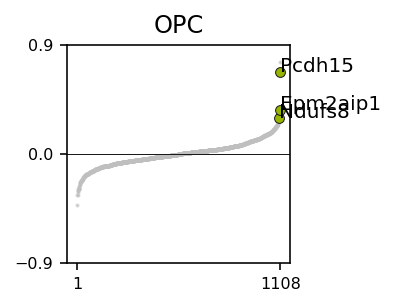

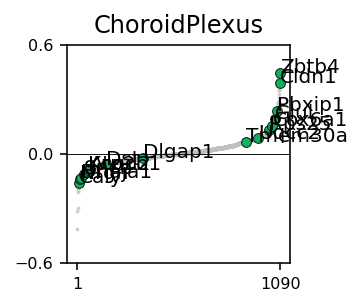

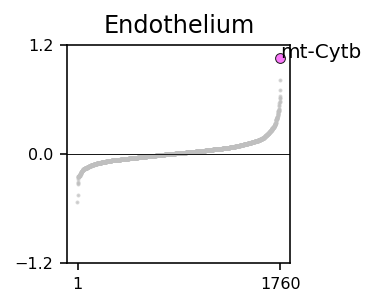

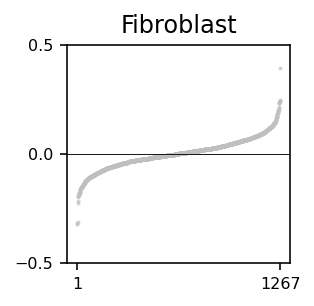

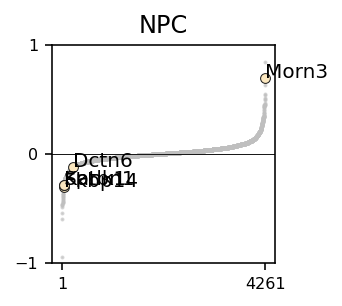

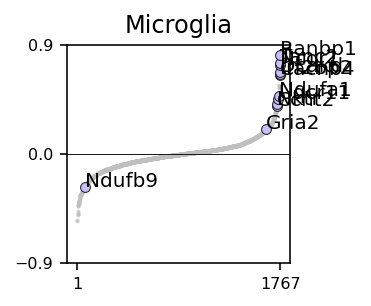

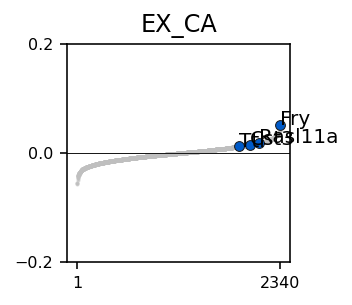

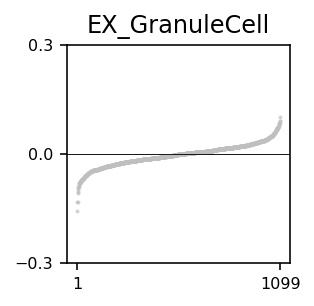

In [154]:
sig_by_cluster = plot_DEG_rank_plot_by_cluster('p65_nCLR', 
                                               params_KA_CT, pvals_KA_CT, sig_KA_CT, 
                                               annotate=True,
                                               figstr='KA_celltype')


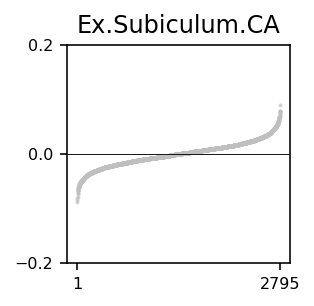

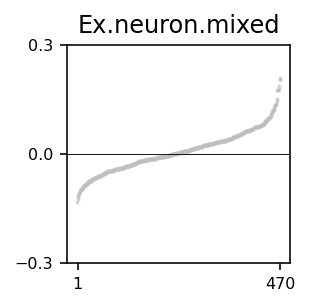

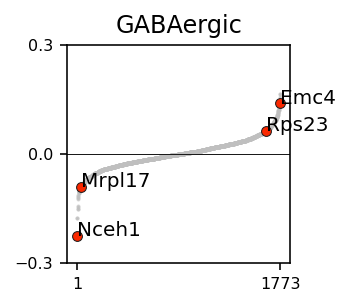

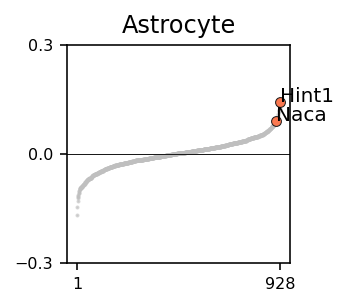

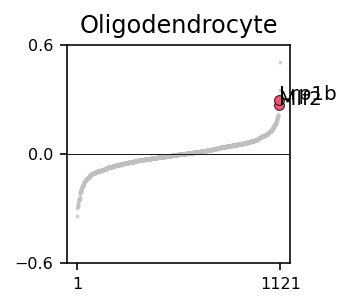

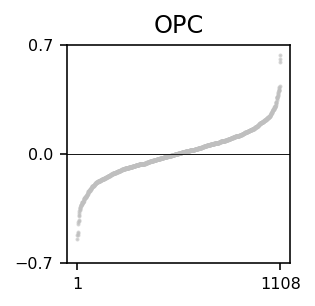

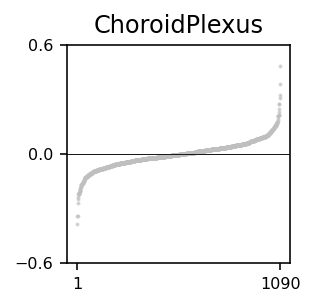

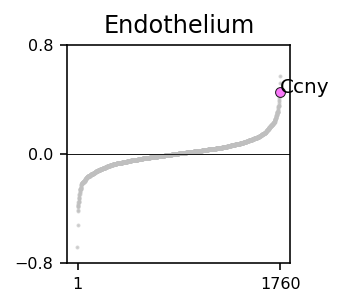

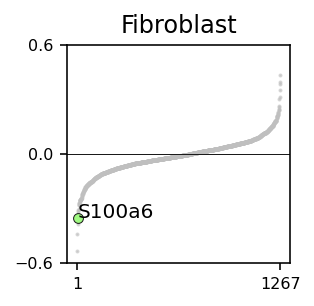

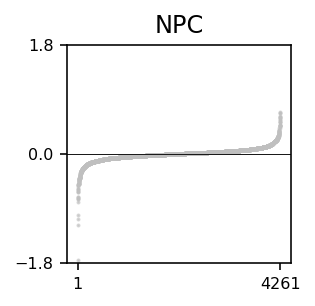

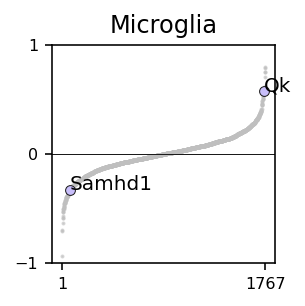

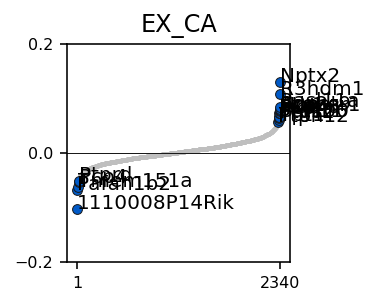

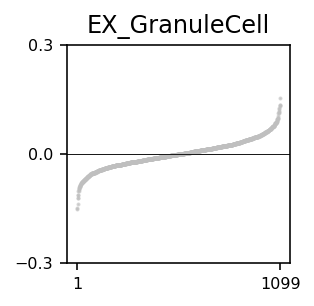

In [148]:
sig_by_cluster = plot_DEG_rank_plot_by_cluster('cFos_nCLR', 
                                               params_KA_CT, pvals_KA_CT, sig_KA_CT, 
                                               annotate=True,
                                               figstr='KA_celltype')
